## Importing Libraries

In [1]:
import os
import h5py
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc, roc_auc_score

## Disable Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Load the data

In [3]:
electrons_data = h5py.File('/kaggle/input/task-1-dataset/Task 1 Data/Electron_dataset.hdf5', 'r')

X_dset_electrons = electrons_data['X']
y_dset_electrons = electrons_data['y']
X_electrons = np.array(X_dset_electrons)
y_electrons = np.array(y_dset_electrons)

print(X_electrons.shape)
print(y_electrons.shape)

photons_data = h5py.File('/kaggle/input/task-1-dataset/Task 1 Data/Photon_dataset.hdf5', 'r')

X_dset_photons = photons_data['X']
y_dset_photons = photons_data['y']
X_photons = np.array(X_dset_photons)
y_photons = np.array(y_dset_photons)

print(X_photons.shape)
print(y_photons.shape)

X = np.concatenate((X_electrons, X_photons), axis = 0)
y = np.concatenate((y_electrons, y_photons), axis = 0).reshape(-1,1)

print(X.shape)
print(y.shape)

(249000, 32, 32, 2)
(249000,)
(249000, 32, 32, 2)
(249000,)
(498000, 32, 32, 2)
(498000, 1)


## Splitting the Data

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.015, random_state=42)

## Convert data to PyTorch tensors

In [5]:
xtrain = torch.tensor(xtrain, dtype=torch.float32).permute(0, 3, 1, 2)
ytrain = torch.tensor(ytrain, dtype=torch.float32)
xtest = torch.tensor(xtest, dtype=torch.float32).permute(0, 3, 1, 2)
ytest = torch.tensor(ytest, dtype=torch.float32)

## Create DataLoader objects

In [6]:
train_dataset = TensorDataset(xtrain, ytrain)
test_dataset = TensorDataset(xtest, ytest)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## ResNet - 15 like model Creation

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
class ResNet15(nn.Module):
    def __init__(self):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, stride=2)
        self.res3 = ResidualBlock(64, 128, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

## Creating Model

In [9]:
def create_model():
    model = ResNet15()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    return model, criterion, optimizer

## Device configuration

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model, criterion, and optimizer

In [11]:
model, criterion, optimizer = create_model()
model = model.to(device)

## Training

In [12]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_loader, desc="Training: "):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.round(torch.sigmoid(outputs))

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc

## Testing

In [13]:
def test(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    true_labels = []
    predicted_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing: "):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.round(torch.sigmoid(outputs))

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

            true_labels.extend(labels.cpu().numpy().flatten())
            predicted_probs.extend(torch.sigmoid(outputs).cpu().numpy().flatten())

        test_loss = running_loss / len(test_loader.dataset)
        test_acc = running_corrects.double() / len(test_loader.dataset)
        roc_auc = roc_auc_score(true_labels, predicted_probs)

    return test_loss, test_acc, roc_auc, true_labels, predicted_probs

## Plotting ROC Curve

In [14]:
def plot_roc_curve(false_pr, true_pr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(false_pr, true_pr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='-.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## Function for Training the Model

Testing: 100%|██████████| 234/234 [00:00<00:00, 408.78it/s]


Epoch [1/50], Train Loss: 0.6617, Train Accuracy: 0.6049
Test Loss: 0.6511, Test Accuracy: 0.6213, ROC AUC: 0.6820


Testing: 100%|██████████| 234/234 [00:00<00:00, 428.62it/s]


Epoch [2/50], Train Loss: 0.6389, Train Accuracy: 0.6372
Test Loss: 0.6257, Test Accuracy: 0.6527, ROC AUC: 0.7144


Testing: 100%|██████████| 234/234 [00:00<00:00, 396.15it/s]


Epoch [3/50], Train Loss: 0.6229, Train Accuracy: 0.6577
Test Loss: 0.6208, Test Accuracy: 0.6620, ROC AUC: 0.7292


Testing: 100%|██████████| 234/234 [00:00<00:00, 408.75it/s]


Epoch [4/50], Train Loss: 0.6077, Train Accuracy: 0.6756
Test Loss: 0.6012, Test Accuracy: 0.6859, ROC AUC: 0.7481


Testing: 100%|██████████| 234/234 [00:00<00:00, 431.29it/s]


Epoch [5/50], Train Loss: 0.5939, Train Accuracy: 0.6900
Test Loss: 0.5831, Test Accuracy: 0.7052, ROC AUC: 0.7671


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.52it/s]


Epoch [6/50], Train Loss: 0.5849, Train Accuracy: 0.6991
Test Loss: 0.5812, Test Accuracy: 0.6987, ROC AUC: 0.7709


Testing: 100%|██████████| 234/234 [00:00<00:00, 432.67it/s]


Epoch [7/50], Train Loss: 0.5786, Train Accuracy: 0.7051
Test Loss: 0.5845, Test Accuracy: 0.6948, ROC AUC: 0.7707


Testing: 100%|██████████| 234/234 [00:00<00:00, 429.61it/s]


Epoch [8/50], Train Loss: 0.5742, Train Accuracy: 0.7087
Test Loss: 0.5774, Test Accuracy: 0.7145, ROC AUC: 0.7758


Testing: 100%|██████████| 234/234 [00:00<00:00, 422.75it/s]


Epoch [9/50], Train Loss: 0.5703, Train Accuracy: 0.7129
Test Loss: 0.5917, Test Accuracy: 0.6960, ROC AUC: 0.7633


Testing: 100%|██████████| 234/234 [00:00<00:00, 432.66it/s]


Epoch [10/50], Train Loss: 0.5681, Train Accuracy: 0.7148
Test Loss: 0.5746, Test Accuracy: 0.7217, ROC AUC: 0.7817


Testing: 100%|██████████| 234/234 [00:00<00:00, 418.25it/s]


Epoch [11/50], Train Loss: 0.5656, Train Accuracy: 0.7168
Test Loss: 0.5783, Test Accuracy: 0.7044, ROC AUC: 0.7792


Testing: 100%|██████████| 234/234 [00:00<00:00, 431.08it/s]


Epoch [12/50], Train Loss: 0.5636, Train Accuracy: 0.7177
Test Loss: 0.5781, Test Accuracy: 0.6972, ROC AUC: 0.7746


Testing: 100%|██████████| 234/234 [00:00<00:00, 429.05it/s]


Epoch [13/50], Train Loss: 0.5618, Train Accuracy: 0.7198
Test Loss: 0.5792, Test Accuracy: 0.7013, ROC AUC: 0.7818


Testing: 100%|██████████| 234/234 [00:00<00:00, 424.86it/s]


Epoch [14/50], Train Loss: 0.5609, Train Accuracy: 0.7206
Test Loss: 0.5661, Test Accuracy: 0.7311, ROC AUC: 0.7886


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.22it/s]


Epoch [15/50], Train Loss: 0.5594, Train Accuracy: 0.7209
Test Loss: 0.5696, Test Accuracy: 0.7190, ROC AUC: 0.7798


Testing: 100%|██████████| 234/234 [00:00<00:00, 428.35it/s]


Epoch [16/50], Train Loss: 0.5582, Train Accuracy: 0.7223
Test Loss: 0.5667, Test Accuracy: 0.7181, ROC AUC: 0.7830


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.89it/s]


Epoch [17/50], Train Loss: 0.5568, Train Accuracy: 0.7232
Test Loss: 0.5621, Test Accuracy: 0.7277, ROC AUC: 0.7872


Testing: 100%|██████████| 234/234 [00:00<00:00, 424.96it/s]


Epoch [18/50], Train Loss: 0.5557, Train Accuracy: 0.7244
Test Loss: 0.5723, Test Accuracy: 0.7224, ROC AUC: 0.7820


Testing: 100%|██████████| 234/234 [00:00<00:00, 424.41it/s]


Epoch [19/50], Train Loss: 0.5547, Train Accuracy: 0.7247
Test Loss: 0.5721, Test Accuracy: 0.7142, ROC AUC: 0.7773


Testing: 100%|██████████| 234/234 [00:00<00:00, 423.85it/s]


Epoch [20/50], Train Loss: 0.5543, Train Accuracy: 0.7260
Test Loss: 0.5773, Test Accuracy: 0.7209, ROC AUC: 0.7802


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.59it/s]


Epoch [21/50], Train Loss: 0.5531, Train Accuracy: 0.7263
Test Loss: 0.5672, Test Accuracy: 0.7228, ROC AUC: 0.7830


Testing: 100%|██████████| 234/234 [00:00<00:00, 426.24it/s]


Epoch [22/50], Train Loss: 0.5524, Train Accuracy: 0.7267
Test Loss: 0.5975, Test Accuracy: 0.6894, ROC AUC: 0.7615


Testing: 100%|██████████| 234/234 [00:00<00:00, 432.49it/s]


Epoch [23/50], Train Loss: 0.5512, Train Accuracy: 0.7280
Test Loss: 0.5584, Test Accuracy: 0.7297, ROC AUC: 0.7918


Testing: 100%|██████████| 234/234 [00:00<00:00, 425.76it/s]


Epoch [24/50], Train Loss: 0.5505, Train Accuracy: 0.7281
Test Loss: 0.5630, Test Accuracy: 0.7182, ROC AUC: 0.7860


Testing: 100%|██████████| 234/234 [00:00<00:00, 429.90it/s]


Epoch [25/50], Train Loss: 0.5501, Train Accuracy: 0.7288
Test Loss: 0.5637, Test Accuracy: 0.7289, ROC AUC: 0.7896


Testing: 100%|██████████| 234/234 [00:00<00:00, 432.81it/s]


Epoch [26/50], Train Loss: 0.5486, Train Accuracy: 0.7296
Test Loss: 0.5901, Test Accuracy: 0.6995, ROC AUC: 0.7604


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.50it/s]


Epoch [27/50], Train Loss: 0.5480, Train Accuracy: 0.7301
Test Loss: 0.5697, Test Accuracy: 0.7153, ROC AUC: 0.7817


Testing: 100%|██████████| 234/234 [00:00<00:00, 432.16it/s]


Epoch [28/50], Train Loss: 0.5479, Train Accuracy: 0.7301
Test Loss: 0.5615, Test Accuracy: 0.7217, ROC AUC: 0.7864


Testing: 100%|██████████| 234/234 [00:00<00:00, 428.88it/s]


Epoch [29/50], Train Loss: 0.5465, Train Accuracy: 0.7309
Test Loss: 0.5518, Test Accuracy: 0.7272, ROC AUC: 0.7949


Testing: 100%|██████████| 234/234 [00:00<00:00, 436.49it/s]


Epoch [30/50], Train Loss: 0.5459, Train Accuracy: 0.7314
Test Loss: 0.5704, Test Accuracy: 0.7169, ROC AUC: 0.7819


Testing: 100%|██████████| 234/234 [00:00<00:00, 429.58it/s]


Epoch [31/50], Train Loss: 0.5447, Train Accuracy: 0.7318
Test Loss: 0.5865, Test Accuracy: 0.7020, ROC AUC: 0.7635


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.23it/s]


Epoch [32/50], Train Loss: 0.5443, Train Accuracy: 0.7324
Test Loss: 0.5723, Test Accuracy: 0.7230, ROC AUC: 0.7832


Testing: 100%|██████████| 234/234 [00:00<00:00, 421.27it/s]


Epoch [33/50], Train Loss: 0.5432, Train Accuracy: 0.7334
Test Loss: 0.5649, Test Accuracy: 0.7207, ROC AUC: 0.7864


Testing: 100%|██████████| 234/234 [00:00<00:00, 428.30it/s]


Epoch [34/50], Train Loss: 0.5424, Train Accuracy: 0.7331
Test Loss: 0.5707, Test Accuracy: 0.7145, ROC AUC: 0.7760


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.70it/s]


Epoch [35/50], Train Loss: 0.5418, Train Accuracy: 0.7338
Test Loss: 0.5681, Test Accuracy: 0.7198, ROC AUC: 0.7808


Testing: 100%|██████████| 234/234 [00:00<00:00, 435.47it/s]


Epoch [36/50], Train Loss: 0.5412, Train Accuracy: 0.7341
Test Loss: 0.5679, Test Accuracy: 0.7264, ROC AUC: 0.7844


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.52it/s]


Epoch [37/50], Train Loss: 0.5402, Train Accuracy: 0.7351
Test Loss: 0.5724, Test Accuracy: 0.7147, ROC AUC: 0.7741


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.74it/s]


Epoch [38/50], Train Loss: 0.5386, Train Accuracy: 0.7360
Test Loss: 0.5709, Test Accuracy: 0.7167, ROC AUC: 0.7761


Testing: 100%|██████████| 234/234 [00:00<00:00, 412.43it/s]


Epoch [39/50], Train Loss: 0.5380, Train Accuracy: 0.7357
Test Loss: 0.5900, Test Accuracy: 0.7080, ROC AUC: 0.7621


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.55it/s]


Epoch [40/50], Train Loss: 0.5368, Train Accuracy: 0.7375
Test Loss: 0.5706, Test Accuracy: 0.7076, ROC AUC: 0.7759


Testing: 100%|██████████| 234/234 [00:00<00:00, 430.53it/s]


Epoch [41/50], Train Loss: 0.5355, Train Accuracy: 0.7384
Test Loss: 0.5649, Test Accuracy: 0.7155, ROC AUC: 0.7825


Testing: 100%|██████████| 234/234 [00:00<00:00, 430.86it/s]


Epoch [42/50], Train Loss: 0.5346, Train Accuracy: 0.7392
Test Loss: 0.5693, Test Accuracy: 0.7257, ROC AUC: 0.7831


Testing: 100%|██████████| 234/234 [00:00<00:00, 433.75it/s]


Epoch [43/50], Train Loss: 0.5331, Train Accuracy: 0.7404
Test Loss: 0.5866, Test Accuracy: 0.7032, ROC AUC: 0.7614


Testing: 100%|██████████| 234/234 [00:00<00:00, 427.91it/s]


Epoch [44/50], Train Loss: 0.5323, Train Accuracy: 0.7404
Test Loss: 0.5904, Test Accuracy: 0.7041, ROC AUC: 0.7641


Testing: 100%|██████████| 234/234 [00:00<00:00, 425.08it/s]


Epoch [45/50], Train Loss: 0.5308, Train Accuracy: 0.7412
Test Loss: 0.5821, Test Accuracy: 0.7098, ROC AUC: 0.7804


Testing: 100%|██████████| 234/234 [00:00<00:00, 405.01it/s]


Epoch [46/50], Train Loss: 0.5299, Train Accuracy: 0.7409
Test Loss: 0.5990, Test Accuracy: 0.6912, ROC AUC: 0.7487


Testing: 100%|██████████| 234/234 [00:00<00:00, 422.21it/s]


Epoch [47/50], Train Loss: 0.5275, Train Accuracy: 0.7428
Test Loss: 0.5946, Test Accuracy: 0.6950, ROC AUC: 0.7552


Testing: 100%|██████████| 234/234 [00:00<00:00, 421.87it/s]


Epoch [48/50], Train Loss: 0.5270, Train Accuracy: 0.7428
Test Loss: 0.5756, Test Accuracy: 0.7167, ROC AUC: 0.7741


Testing: 100%|██████████| 234/234 [00:00<00:00, 431.68it/s]


Epoch [49/50], Train Loss: 0.5251, Train Accuracy: 0.7439
Test Loss: 0.5837, Test Accuracy: 0.7029, ROC AUC: 0.7672


Testing: 100%|██████████| 234/234 [00:00<00:00, 432.06it/s]


Epoch [50/50], Train Loss: 0.5232, Train Accuracy: 0.7442
Test Loss: 0.5819, Test Accuracy: 0.7116, ROC AUC: 0.7715


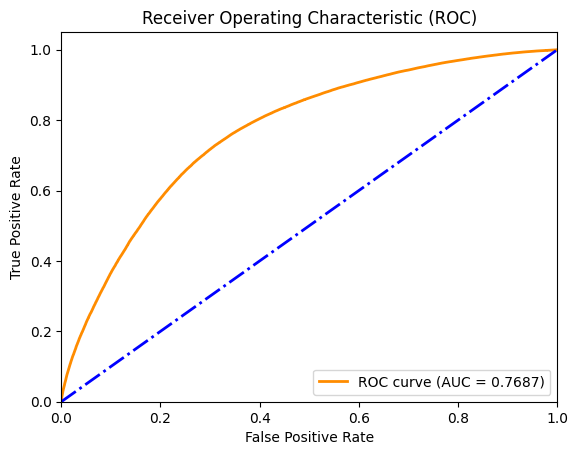

In [15]:
def run_training(model, criterion, optimizer, train_loader, test_loader, device, num_epochs = 50):
    all_true_labels = []
    all_predicted_probs = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, train_loader, device)
        test_loss, test_acc, roc_auc, true_labels, predicted_probs = test(model, criterion, test_loader, device)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, ROC AUC: {roc_auc:.4f}')

        # Accumulate true labels and predicted probabilities
        all_true_labels.extend(true_labels)
        all_predicted_probs.extend(predicted_probs)

    # Calculate the false positive rate, true positive rate, and thresholds
    false_pr, true_pr, _ = roc_curve(all_true_labels, all_predicted_probs)

    # Calculate the ROC AUC
    roc_auc = auc(false_pr, true_pr)

    # Plot the ROC curve
    plot_roc_curve(false_pr, true_pr, roc_auc)

run_training(model, criterion, optimizer, train_loader, test_loader, device)